In [1]:
import recirq
import qsimcirq

import cirq
import matplotlib.pyplot as plt

import recirq.toric_code.toric_code_plaquettes as tcp
import recirq.toric_code.toric_code_plotter as tcplot
import recirq.toric_code.toric_code_rectangle as tcr
import recirq.toric_code.toric_code_state_prep as tcsp

plt.rcParams['figure.dpi'] = 144

<Axes: >

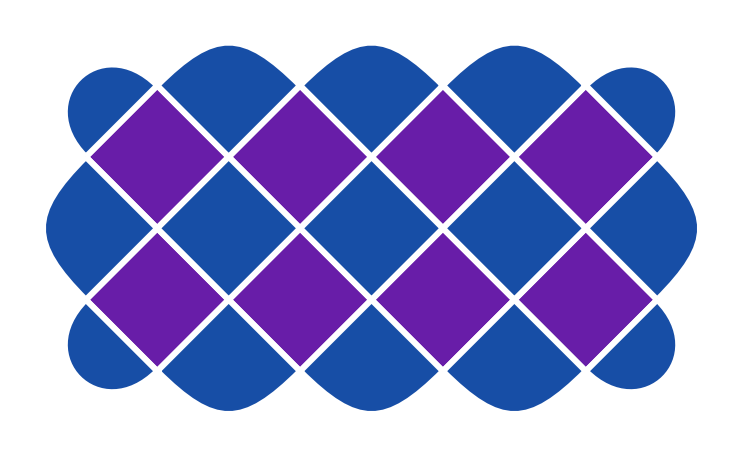

In [2]:
short_rectangle = tcr.ToricCodeRectangle(
    origin_qubit=cirq.GridQubit(3, 0), row_vector=(1, 1), rows=2, cols=4
)
plotter = tcplot.ToricCodePlotter()
plotter.plot_code(short_rectangle)

In [3]:
full_circuit = tcsp.toric_code_cnot_circuit(short_rectangle)
for idx, moment in enumerate(full_circuit):
    print(f'moment {idx}\n{moment}\n')

moment 0
  ╷ 0 1 2 3 4
╶─┼───────────
0 │       H
  │
1 │     H   H
  │
2 │   H   H
  │
3 │ H   H
  │
4 │   H
  │

moment 1
  ╷ 1 2 3
╶─┼───────
1 │   @
  │   │
2 │ @ X @
  │ │   │
3 │ X @ X
  │   │
4 │   X
  │

moment 2
  ╷ 1 2 3 4
╶─┼─────────
1 │   @─X
  │
2 │ @─X @─X
  │
3 │   @─X
  │

moment 3
  ╷ 0 1 2 3 4 5
╶─┼─────────────
0 │       @─X
  │
1 │       @ @─X
  │       │
2 │       X @
  │         │
3 │ @ @─X   X
  │ │
4 │ X @ @─X
  │   │
5 │   X
  │

moment 4
  ╷ 0 1 2 3 4
╶─┼───────────
0 │       @
  │       │
1 │       X @
  │         │
2 │         X
  │
3 │ @─X
  │
4 │   @─X
  │

moment 5
  ╷ 0 1 2 4 5
╶─┼───────────
0 │       @
  │       │
1 │       X @
  │         │
2 │         X
  │
4 │ @─X
  │
5 │   @─X
  │



In [4]:
def partial_circuit(
    n_moments_to_include: int, *, x_basis: bool
) -> cirq.Circuit:
    """Create the first N moments of a toric in Z or X basis.

    Args:
        n_moments_to_include: number of moments to include
        x_basis: If True, add Hadamards to effectively measure in the X basis.
            If False, measure in the computational (Z) basis.

    Returns: First N moments of a toric code circuit plus an optional
        layer of Hadamard gates to effectively measure in the X basis.
        This circuit also includes measurement gates.
    """
    sliced_circuit = full_circuit[:n_moments_to_include]
    qubits = sorted(short_rectangle.qubits)
    if x_basis:
        sliced_circuit += cirq.Moment(cirq.H.on_each(*qubits))
    return sliced_circuit + cirq.measure(*qubits)


def get_plaquettes(
    n_moment_to_include: int, repetitions: int = 1000,
    sampler: cirq.Sampler = qsimcirq.QSimSimulator()
) -> tcp.ToricCodePlaquettes:
    """Simulates the results in both bases and determine plaquette values.

    Args:
            n_moments_to_include: number of moments to include
            repetitions: number of repetitions (shots) to sample
            sampler: Sampler (simulator) to execute circuits.  Defaults to qsim.
    """
    x_data = sampler.run(
        partial_circuit(n_moment_to_include, x_basis=True), repetitions=repetitions
    )
    z_data = sampler.run(
        partial_circuit(n_moment_to_include, x_basis=False), repetitions=repetitions
    )
    return tcp.ToricCodePlaquettes.from_global_measurements(
        short_rectangle, x_data.data, z_data.data
    )

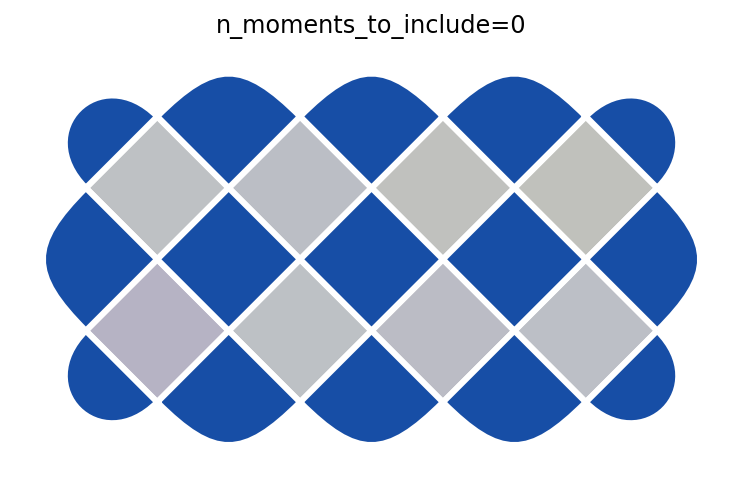

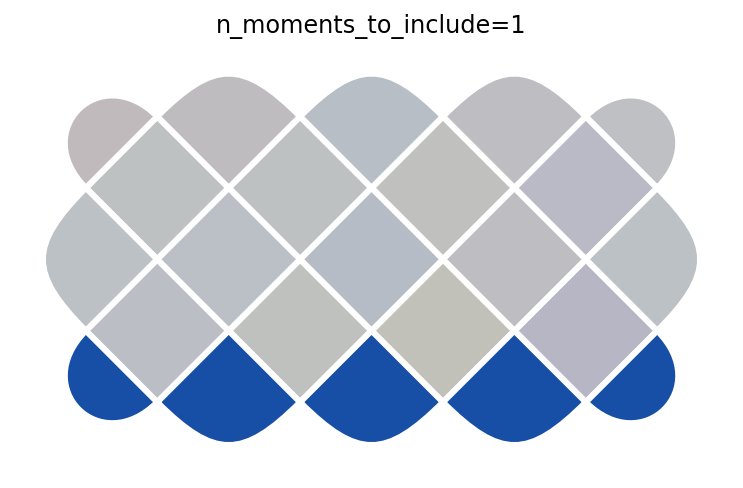

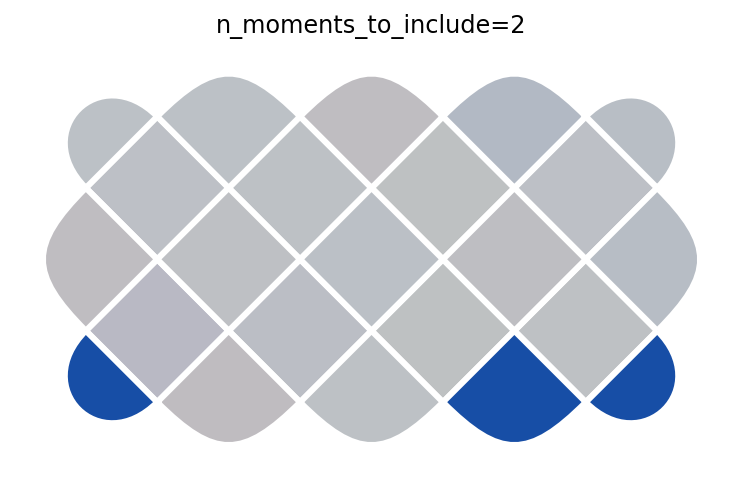

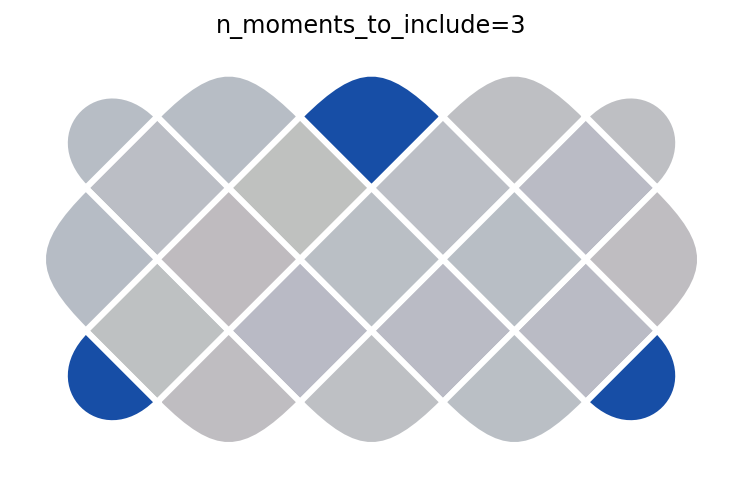

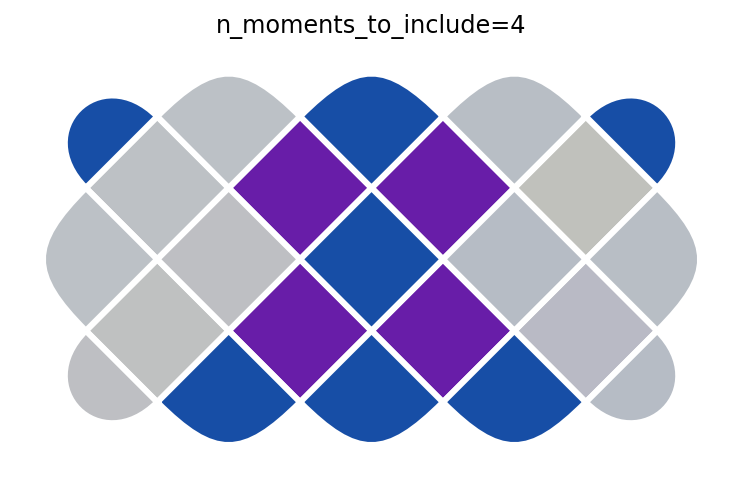

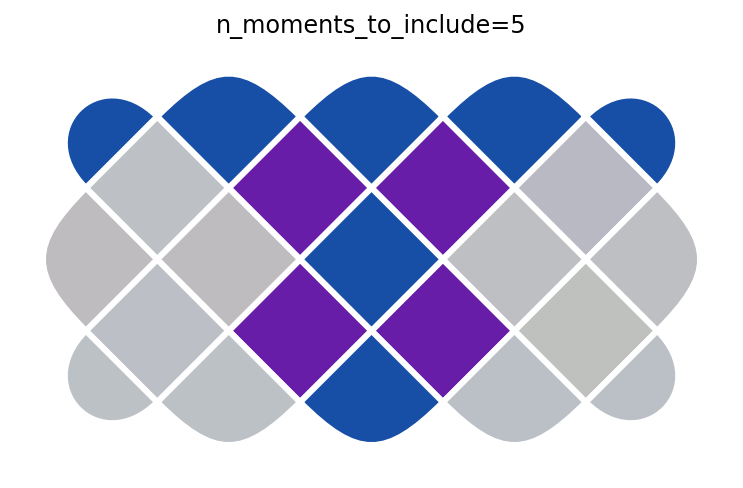

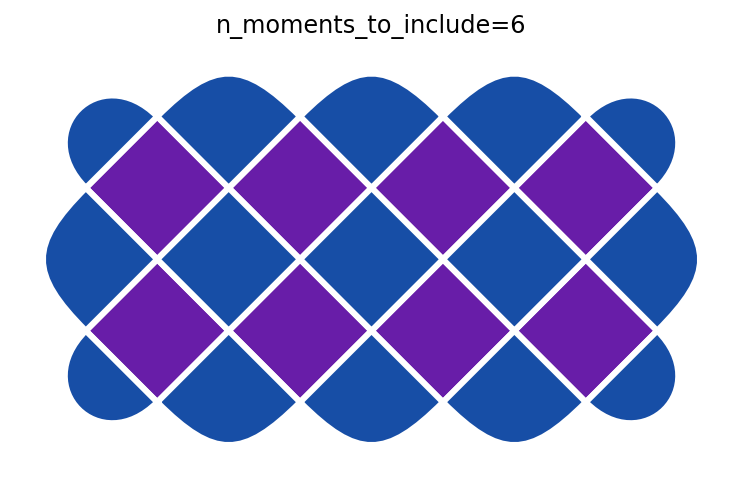

In [5]:
for n in range(len(tcsp.toric_code_cnot_circuit(short_rectangle)) + 1):
    p = get_plaquettes(n)
    ax = plotter.plot_expectation_values(p)
    ax.set_title(f'n_moments_to_include={n}')
    plt.pause(0.001)

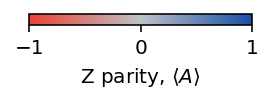

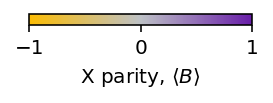

In [6]:
ax_z = plotter.make_colorbar(x_basis=False, orientation='horizontal')
ax_z.set_label(r'Z parity, $\langle A\rangle$')

ax_x = plotter.make_colorbar(x_basis=True, orientation='horizontal')
ax_x.set_label(r'X parity, $\langle B\rangle$')